# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Well, ICA discovers underlying statistically independent causes. So, while it is the case that our data consists of the yearly net price of all products in various categories ordered by stores, there may be independent trends consisting of combinations of the categories that get revealed, corresponding to maybe a part of a store or type of store or independent variance attributable to geographic position. In the context of our lesson, we may find a component that corresponds to some shared property of small stores that might help us solve our dilemma. 

PCA will find what spread of features describes our data. So it'll tell me what, in essence, what ratios of goods stores tend to order, and the best first correction to that.  I don't expect the PCA components themsleves to be too useful by itself, since here the large features will tend to swamp out the smaller ones.  Fresh has the most variance, and seems to vary greatly between customers so I expect it to show up prominently in the first PCA component.

###PCA

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


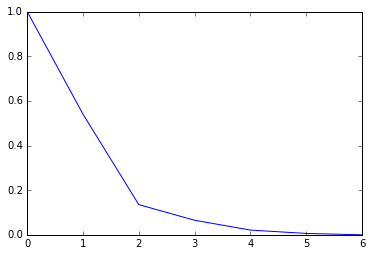


Scaled PCA

[[-0.04288396 -0.54511832 -0.57925635 -0.05118859 -0.5486402  -0.24868198]
 [-0.52793212 -0.08316765  0.14608818 -0.61127764  0.25523316 -0.50420705]
 [-0.81225657  0.06038798 -0.10838401  0.17838615 -0.13619225  0.52390412]
 [-0.23668559 -0.08718991  0.10598745  0.76868266  0.17174406 -0.55206472]
 [ 0.04868278 -0.82657929  0.31499943  0.02793224  0.33964012  0.31470051]
 [ 0.03602539  0.03804019 -0.72174458  0.01563715  0.68589373  0.07513412]]
[ 0.44082893  0.283764    0.12334413  0.09395504  0.04761272  0.01049519]


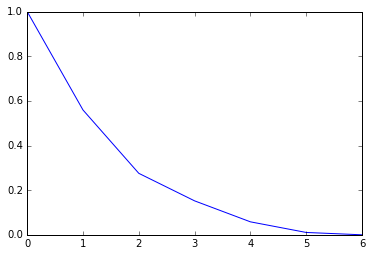

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(copy=True)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

# Visualize the cutoff
plt.plot(1-np.cumsum(np.insert(pca.explained_variance_ratio_,0,0)))
plt.axis([0,6,0,1])
plt.show()

# What if every feature was equally scaled?
pca_prime = PCA()
scaled_data = data / data.std(axis=0)
pca_prime.fit(scaled_data)

print "\nScaled PCA\n"
print pca_prime.components_
print pca_prime.explained_variance_ratio_

plt.plot(1-np.cumsum(np.insert(pca_prime.explained_variance_ratio_,0,0)))
plt.axis([0,6,0,1])
plt.show()

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

It drops off quite quickly after the first two components. The first two components jointly describe about 85% of the variance. The cliff after the second principal component seems to suggest the second PC a good cutoff point; the components afterwards aren't explaining very much variance.  On the graph you can see 

**3)** What do the dimensions seem to represent? How can you use this information?

The first dimension, at least, can be interpreted as the typical store ratio of orders.  What I mean by that is that if we consider all possible feature vectors, this is the one that gets closest to describing the data by itself, up to a constant multiplier. The first two are then just the two feature vectors that do as above.  The first component consists almost entirely of the Fresh category, along with a small positive correlation with the other categories as well, which seems representative of the ordering profile of a restaurant or anywhere else food is prepared, with its very strong focus on Fresh ingredients (Or rather, the opposite of all this since the largest parts of the PCA components are all negative).

The second category, however has a different interpretation.  It's three most prominent components are Grocery, Milk, and Paper/Detergents, in that order.  Those things sound exactly like what you got to a small corner store or small grocery store to get, it has a negative correlation for frozen and fresh because a small store like that may not have space for these things.  

Thus, despite what I initially thought would be the case, PCA does seem to indentify small stores, their spread of orders seems to be represented in the second PCA component; the first PCA component seems to be an indication of what larger customers are like.

If we scale our data to unit variance before doing the PCA analysis, we get data that looks very different on the surface, but after a bit of thought is actually quite similar.  The first PCA component (henceforth PCA1), consists rather evenly of Milk, Grocery, and Paper, and the second PCA component pretty evenly of Fresh, Frozen, and Deli, with a non-trivial but small anticorrelation with Paper and Grocery.  The large differences between the magnitudes of the different main contributions to each component nearly vanished, and it seems that the features swapped places!  What I previously described as a PCA component corresponding to a smaller store / grocery store profile of orders is now the first component and the restaurant style ordering profile the second one.  

We can glean about as much from this PCA analysis as the last one, although it does reinforce the validity of the previous analysis as being an inherent description of the most important ordering profiles and not just an artifact of the different magnitudes of our categories.  One thing to note though, is that the stated variance described by the second PCA analysis feels more accurate.  What I mean is that it isn't 'cheating' by just describing a lot of the variance of the categories that overwhelm the others, but it truly describes the variance in ordering 'profiles', and hence is actually more useful for categorizing customers than the first even if the first two components describe less of the variance (72.45%).  Notably, we could argue for the inclusion of more components here, but having two components as a cuttoff point is still really good, not to mention it's easier to visualize two-dimentional data than it is to visualize data with more dimensions.

###ICA

Mean Component Values
[[ 1.         -0.12836442 -0.12953472 -0.06492544  0.20788799 -0.05639315]
 [ 0.02866213  1.         -0.75520885 -0.02350706  0.22705674 -0.2358449 ]
 [ 0.04007053 -0.21974488  1.          0.02745783 -0.11980633 -0.06747741]
 [-0.20199713 -0.01964304  0.13649125  1.         -0.04846484 -0.31031462]
 [ 0.02704208 -0.13310814 -0.83740173  0.05344281  1.          0.12039391]
 [-0.0960108  -0.03225075 -0.11136621 -0.0494368   0.04763794  1.        ]]
STD of Component Values
[[ 0.          0.00407042  0.01362858  0.00059016  0.01411681  0.00284008]
 [ 0.0083461   0.          0.070543    0.00207893  0.01411776  0.00796341]
 [ 0.00478026  0.05404569  0.          0.00614831  0.06596449  0.01973268]
 [ 0.00048405  0.0015978   0.00352109  0.          0.00129619  0.0022417 ]
 [ 0.00135639  0.0089794   0.01749965  0.0008047   0.          0.00085047]
 [ 0.00058457  0.00275429  0.00357054  0.00250576  0.00164621  0.        ]]
Inverse Matrix
[[ 1.03415807  0.11167148  0.02076289

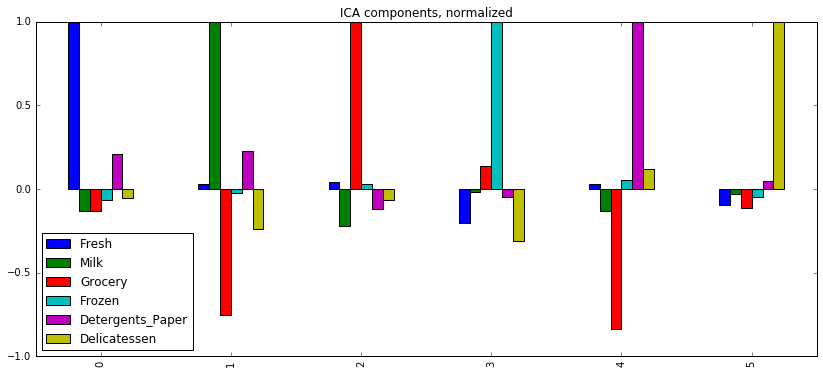

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

# Adjusting data to have zero mean
data_mean = np.mean(data)
data_std = np.std(data)
adjusted_data = data - data_mean

# Just making sure we did this right...
np.testing.assert_allclose(np.mean(adjusted_data) , np.zeros(6), atol=1.0e-10)

def reorder_rescale(mat, multiplier=1):
    """
    Reorders the rows of the matrix mat so that all of the maximal (in the absolute sense)
    values of each row lie on the main diagonal of the matrix, and normalizes the values of the rows
    such that all values on the diagonal are equal to one, for the sake of readability
    """
    indices = []
    retMatrix = []
    for row in mat:
        max = 0.
        ele_num = -1
        for n, ele in enumerate(row):
            if abs(ele) >= max:
                max = abs(ele)
                ele_num = n
        retMatrix.append(row)       
        indices.append(ele_num)
    rowOrder = []
    for n in range(len(indices)):
        if n in indices:
            rowOrder.extend([a for a, b in enumerate(indices) if b == n])
    retMatrix = (np.array(retMatrix)*multiplier)[rowOrder]
    for k, row in enumerate(retMatrix):
        retMatrix[k] /= retMatrix[k][indices[rowOrder[k]]]
    return retMatrix

def has_unit_diagonal(matrix):
    size = len(matrix)
    tol = 10**(-8)
    for n in range(size):
        if abs(matrix[n][n]-1) > tol:
            return False
    return True

def run_ica(times=5):
    """Runs ICA several times, identifies common components, normalizes the rows such that their maximal element
    in absolute value is set to +1, and reorganizes the rows so that all elements on the diagonal are +1,
    before averaging"""

    means = [[0 for x in range(6)] for x in range(6)]
    stds = [[0 for x in range(6)] for x in range(6)]
    component_matrix_array = []
    for x in range(times):
        ica = FastICA()
        source_data = ica.fit_transform(adjusted_data)
        source_data_std = np.std(source_data, axis=0)
        component_matrix_array.append(reorder_rescale(ica.components_, [x/source_data_std[n] for n,x in enumerate(data_std)]))
    
    
    component_matrix_array = [x for x in component_matrix_array if has_unit_diagonal(x)]
    times = len(component_matrix_array)
    
    #Find Mean
    for matrix in component_matrix_array:
        for n, row in enumerate(matrix):
            for m, element in enumerate(row):
                means[n][m] += (element/times)

    #Find STD
    for matrix in component_matrix_array:
        for n, row in enumerate(matrix):
            for m, element in enumerate(row):
                stds[n][m] += ((element - means[n][m])**2 / times)
    stds = np.sqrt(stds)
    
    np.set_printoptions(suppress=True)
    

    frac_std =  [[0 for x in range(6)] for x in range(6)]
    for n, row in enumerate(frac_std):
        for m, element in enumerate(row):
            frac_std[n][m] = np.abs(stds[n][m] / means[n][m])
    print "Mean Component Values"
    print np.array(means)
    print "STD of Component Values"
    print np.array(stds)
    print "Inverse Matrix"
    print np.linalg.inv(np.array(means))
    np.set_printoptions(precision=6)
    
    components = pd.DataFrame(np.array(means))
    components.columns = data.columns
    ax = components.plot(kind="bar", title="ICA components, normalized", figsize = (14,6))
    ax.plot()
    return components, means
ICA_outputs = run_ica(200)

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

An advantage of the Gaussian Mixture method is that since we're assuming our data is generated by a mixture of Gaussian distributions, every data point has some probability that it belongs to one of the Gaussians. It doesn't have a hard cutoff, and since in this case I don't feel like I know very much about the data, I would rather see each point have a component belonging to each Gaussian instead of a hard assignment to a particular mean value. Furthermore, Gaussian mixture models more accurately model odd cluster shapes.  Gaussian Mixture models can have pathological convergence problems, but those can usually be solved by proper choice of parameters and preprocessing of data.

However, the Gaussian Mixture models are generally slower than k-means to run.  Furthermore, k-means is much simpler both conceptually and in practice compared to the Gaussian Mixture methods.  Also, as we can see below, our data is not really gaussian, or at least it isn't before undergoing some sort of transformation.  If we hit our data with a logarithm though... It looks a lot more normally distributed!  Not to mention it spreads out the values instead of having them all be clumped near the origin.  Upon doing PCA again, we see that the results we get are subject to the same interpretation as the ones with the categories scaled to unit variance, so we should be fine using the log-data in its place.  The PCA components themselves have a nice distribution after being done on log data as well.

As for which clustering method to use, after looking at histograms and scatter plots of the log-data, it seems that K-means gives the most meaningful cluster boundaries, since the data doesn't neatly split into gaussians for use with a Gaussian Mixture model.  Yes, the log-data is approximately Gaussian, but having one big cluster isn't very instructive, if we want just one center to our data we can always just use the mean of the data, however we're looking to reveal more structure than that, so K-means will be our clustering algorithm of choice here.

The last thing that must be decided is the number of clusters to be used.  If we look at the last of the histograms and graphs immediately below, at the histogram for PCA1 on log data, we can immediately see how we can split the data along either side of zero.  Hence, division into two clusters should at least be possible.  There really doesn't seem to be much of a basis for splitting into more clusters, and attempting the actual clustering seems to back this up.

Histogram of categories


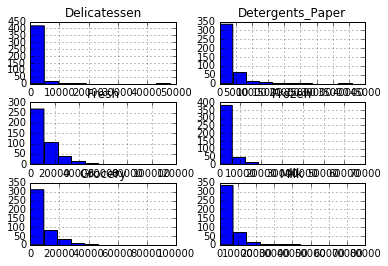

Histogram of log categories


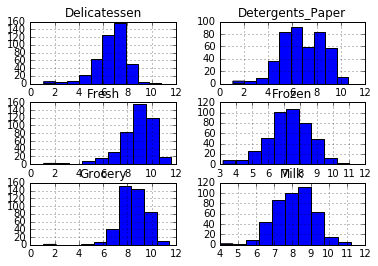


PCA on log-scaled data

[[-0.173717  0.394463  0.454364 -0.172196  0.745515  0.149436]
 [ 0.685136  0.162399  0.069379  0.487691  0.041912  0.509709]
 [ 0.673512 -0.033068  0.032183 -0.284811  0.218244 -0.644597]
 [-0.214326  0.018558  0.064487  0.806083  0.19005  -0.51349 ]
 [ 0.000822 -0.722288 -0.347993  0.036243  0.563665  0.195366]
 [ 0.029276 -0.543035  0.813908  0.017448 -0.202444  0.022832]]
[ 0.442374  0.276571  0.116173  0.096177  0.045757  0.022947]


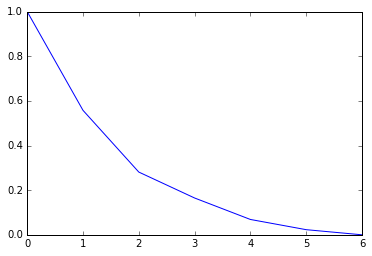

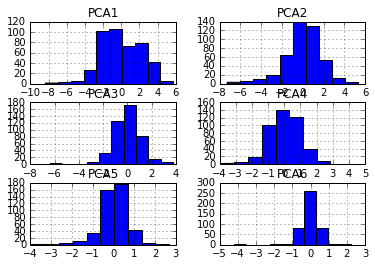

In [4]:
print "Histogram of categories"
pd.DataFrame.hist(data)
plt.show()

print "Histogram of log categories"
pd.DataFrame.hist(np.log(data))
plt.show()

print "\nPCA on log-scaled data\n"
pca3 = PCA()
really_scaled_data = np.log( data / data.std(axis=0) )
pca3.fit(really_scaled_data)

print pca3.components_
print pca3.explained_variance_ratio_

plt.plot(1-np.cumsum(np.insert(pca3.explained_variance_ratio_,0,0)))
plt.axis([0,6,0,1])
plt.show()

pca3_dataframe = pd.DataFrame(data=pca3.transform(really_scaled_data),columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6'])
pd.DataFrame.hist(pca3_dataframe)
plt.show()

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(np.log(data / data.std(axis=0)))
print reduced_data[:10]  # print upto 10 elements

[[ 1.750985  0.070515]
 [ 1.800365  0.869754]
 [ 1.893736  1.676621]
 [-1.127313  1.457982]
 [ 0.796711  2.460866]
 [ 1.083824  0.392942]
 [ 1.13261  -0.201602]
 [ 1.582474  0.968196]
 [ 0.871825 -0.596759]
 [ 2.888883  0.741103]]


In [7]:
# Condensated several steps into one convenient function to graph the results of a clustering.

def graph_clusters(reduced_data, clusters):     
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # TODO: Find the centroids for KMeans or the cluster means for GMM 
    centroids = clusters.means_ if isinstance(clusters,GMM) else clusters.cluster_centers_
    print "-- Centers --"
    print centroids
    print "-- Centers in Original Coordinates --"
    vectors = pca2.inverse_transform(centroids)
    for v in vectors:
        print (np.exp(v) * data.std(axis=0))
        
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')


    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())
    plt.axis([x_min, x_max, y_min, y_max])
    plt.show()

-- Centers --
[[-1.504351  0.164155]
 [ 2.21427  -0.241622]]
-- Centers in Original Coordinates --
Fresh               8994.280204
Milk                1908.923867
Grocery             2366.187501
Frozen              2080.775809
Detergents_Paper     290.422230
Delicatessen         681.298712
dtype: float64
Fresh                3570.082284
Milk                 7748.505394
Grocery             12462.617477
Frozen                899.888171
Detergents_Paper     4567.020517
Delicatessen          965.713272
dtype: float64


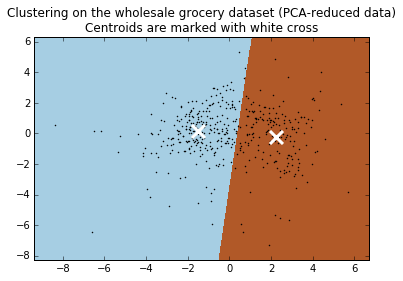

-- Centers --
[[ 2.027771 -2.312928]
 [-1.783598 -0.028749]
 [ 1.587554  1.214244]]
-- Centers in Original Coordinates --
Fresh                892.133951
Milk                5142.578906
Grocery             9917.393601
Frozen               338.399647
Detergents_Paper    3643.744429
Delicatessen         326.762882
dtype: float64
Fresh               8272.469145
Milk                1657.084169
Grocery             2056.523264
Frozen              1987.242967
Detergents_Paper     233.940808
Delicatessen         592.260342
dtype: float64
Fresh               10793.301986
Milk                 7665.389412
Grocery             10370.687132
Frozen               2038.972541
Detergents_Paper     3042.418142
Delicatessen         1846.931679
dtype: float64


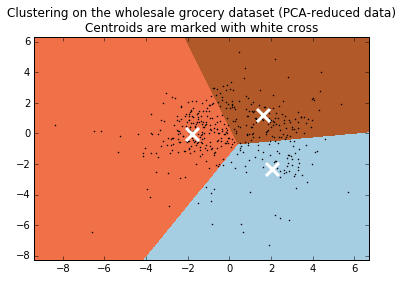

-- Centers --
[[ 1.534037  0.359204]
 [-1.534371  0.282482]
 [-0.41963  -1.469219]]
-- Centers in Original Coordinates --
Fresh               6064.208603
Milk                6532.221145
Grocery             9538.586312
Frozen              1356.172047
Detergents_Paper    2820.513421
Delicatessen        1184.957598
dtype: float64
Fresh               9804.812660
Milk                1923.052932
Grocery             2353.372476
Frozen              2215.807217
Detergents_Paper     285.406574
Delicatessen         720.414481
dtype: float64
Fresh               2432.868949
Milk                2246.027687
Grocery             3458.433724
Frozen               778.313537
Detergents_Paper     608.839216
Delicatessen         348.469808
dtype: float64


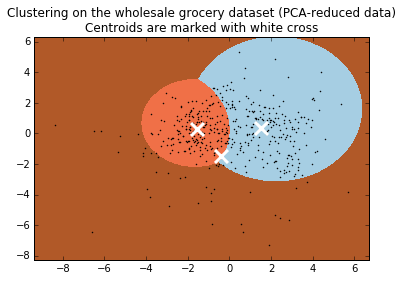

In [8]:
# Try three different clusterings

meanClusters2 = KMeans(n_clusters=2)
meanClusters2.fit(reduced_data)
graph_clusters(reduced_data, meanClusters2)

meanClusters3 = KMeans(n_clusters=3)
meanClusters3.fit(reduced_data)
graph_clusters(reduced_data, meanClusters3)

gaussianClusters = GMM(n_components=3)
gaussianClusters.fit(reduced_data)
graph_clusters(reduced_data, gaussianClusters)



**7)** What are the central objects in each cluster? Describe them as customers.

If we look at one center, it has abnormally high amounts in the Grocery, Milk, and Detergents/Paper categories.  They are either near or exceed the actual maximal values in the data.  The reason for this is that the PCA was done on the log unit-variance scaled data, and the variacne explained doesn't cut off as quickly as it does on the unmodified data, hence it's understandable that the first two PCA components produce clusters with centers that can't actually be customers.  However, it's still very interpretable, and in this case it can be interpreted as the typical Grocery store, since those three categories would be expected to dominate in such a case.

For the other center, it consists of a large amount of Fresh along with a good amount of Frozen.  This center is to the left and covers a greater range of data points than the other.  However, despite that I still think that we can interpret this cluster center as corresponding to a typical customer in Food Service, ordering mostly Fresh and Frozen ingredients in order to cook and serve.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

I feel that, in conjunction with more domain knowledge and more knowledge of the data and where it comes from, these techniques would have been much more useful.  But as is, I'm confronted mostly with numbers and six inprecise labels. Out of all the techniques used here, I would say clustering was the least useful since it revealed very little and since the data didn't divide that neatly into clusters.

The interpretations given for the ICA component vectors are a bit tenuous, but it seems like it was the most promising out of all of them.  With greater access to information regarding the origin of the data, it may have been possible to determine with greater accuracy what the ICA components actually correspond to.  However, as is, the ICA analysis did prove somewhat useful.  From our analysis, it seems that grocery stores/supermarkets, hotels, restaurants, delicatessens are among the company's customers. Although the identities of the customers behind the ICA components is part conjecture, the conjectures involved are at least plausible, and with greater future data that might identify customers, or with possible investigation of groups of customers, even more light can be shed on what the ICA components actually correspond to.

**9)** How would you use that technique to help the company design new experiments?

Whenever we perform A/B testing, it is vital that we evenly distribute our testing across vital customer attributes.  In the context of this assignment, this can mean that we may want to distribute testing across small and large customers, and possibly among the different types of customers.

The most basic thing we can do is to segment our A/B testing to contain representatives from all three of the clusters found above, so we know how changes affect all of them and don't let the fact that, say cluster 2 contains most of our customers, obscure the effects of a test on members of cluster 1 and cluster 3.

However, as for ICA, the technique that I said gave the most insight into the data in the previous question, we could use it as follows: We could form (overlapping) bins by categorizing whether a customer has an above or below average value in a certain ICA component, then insist that any sample of customers we choose draw from all of those bins and either ensure that an A/B test succeeds in all of the bins, or to at the very least pay attention to what happens in every bin into the conclusions of the test.

For any customer, calculate for it a vector with values taken from {0,1} depending on whether it has greater than or less than the mean value in the ith ICA component.  Every possible vector combination should exist in the data, for the ICA components, by construction, should not correlate with each other, and since the number of possibile vector values (2^6 = 64) is much less than the total number of data points.  We can then just make sure to pick customers from each one of these sixty-four bins when we do our testing, and if we see certain bins have different results from others, we can use them to see where these differing results occur.  Maybe most of the bins with low ICA3 get different results than the rest so possibly grocery stores are especially impacted by a change, or a combination of factors could be responsible as well like in the case where low ICA2 coupled with high ICA4 seems to cause a change being tested by A/B testing to not perform well.

**10)** How would you use that data to help you predict future customer needs?

The usefulness of the data for predicting future customer needs is varied.  If used in conjunction with surverys, we can use the knowledge we've found so far in order to properly segment customers into categories which we can them sample from and hence find targeted advice to the different groups to which they belong.

If we want to use supervised learning techniques, this sort of exploratory analysis that we conducted above is extremely useful.  ICA provides more effective components to learn on, and in the case that we have too many dimensions to effectively run our algorithms, we can use PCA to reduce the amount of dimensions to maybe three or four before feeding it into, say, a neural network or a support vector machine.  While some methods, like the boosting methods I employed in the last project, don't need data preprocessing, others, like support vector machines, benefit greatly from their use.  However, the dimensionality reduction we can do with PCA would be great for fitting a regression.